# Varying Add8 Drive Strength

    syn to see what timing is --> CLOCK PERIOD
    power-rtl to generate checkpoint

    generate testbench (vectors, clock period)
    sim-rtl
    redo-power-rtl (load checkpoint)


In [46]:
import yaml
import os
import matplotlib.pyplot as plt
import numpy as np


design='add8'
pdk='sky130'
# pdk='intech22'
tools='cm'

dut_instance='adder0'

root_dir=os.path.abspath(f"{os.getcwd()}/../")
build_dir=f"{root_dir}/build-{pdk}-{tools}/{design}"
out_dir=os.path.abspath(f"{os.getcwd()}/../../out")
jpower_reports_dir = f"{out_dir}/jpower-reports/{design}-{pdk}"
generated_src_dir = f"{root_dir}/generated-src"
generated_configs_dir = f"{root_dir}/generated-configs"
bsub="bsub -q normal"
overwrite=True

os.makedirs(generated_src_dir, exist_ok=True)
os.makedirs(generated_configs_dir, exist_ok=True)


## Useful Functions

In [47]:
def get_test_name(tb_name):
    args = tb_name.replace('_-','_n').split('-')
    in0_args = args[1].split('_')
    in1_args = args[2].split('_')
    in0_initial = in0_args[1].replace('n','-')
    in0 = in0_args[2].replace('n','-')
    in1_initial = in1_args[1].replace('n','-')
    in1 = in1_args[2].replace('n','-')
    ret = f"({in0_initial},{in1_initial}) -> ({in0} + {in1})"
    return ret


def generate_verilog(in_vals, in_initial=(0,0), CLOCK_PERIOD=1):
    in0_initial,in1_initial = in_initial
    in0,in1 = in_vals
    tb_name=f"add8-in0_{in0_initial}_{in0}-in1_{in1_initial}_{in1}"
    verilog=f"""\
    `timescale 1ns/10ps

    `define WIDTH 8

    module add8_tb;

        reg clk = 0;
        always #({CLOCK_PERIOD}/2.0) clk = ~clk;

        reg [`WIDTH-1:0] in0, in1;
        wire [`WIDTH-1:0] out;

        add8 add8_dut ( .clock(clk), .in0(in0), .in1(in1), .out(out) );

        initial begin
            in0 = {'-' if in0_initial < 0 else ''}`WIDTH'd{abs(in0_initial)}; in1 = {'-' if in1_initial < 0 else ''}`WIDTH'd{abs(in1_initial)};
            @(negedge clk);
            $fsdbDumpfile("{tb_name}.fsdb"); $fsdbDumpvars("+all"); $fsdbDumpon;
            in0 = {'-' if in0 < 0 else ''}`WIDTH'd{abs(in0)}; in1 = {'-' if in1 < 0 else ''}`WIDTH'd{abs(in1)};
            @(posedge clk); @(negedge clk);
            $fsdbDumpoff; $finish;
        end
    endmodule
    """

    with open(f"{generated_src_dir}/{tb_name}.v",'w') as f:
        f.write(verilog)
    return tb_name



def generate_config(tb_name):
    cfg = {
        'vlsi.core.power_tool': "hammer.power.joules",

        'power.inputs':
        {
            'level': 'rtl',
            'input_files': ["src/add8.v"],
            'top_module': "add8",
            'tb_name': "add8_tb",
            'tb_dut': "add8_dut",
            'waveforms': [],
            # 'waveforms': ["build-intech22-cm/add8/sim-rtl-rundir/output.fsdb"],
            'report_configs':[
                {
                # 'waveform_path': f"{build_dir}/sim-rtl-rundir/{tb_name}.fsdb",
                'waveform_path': f"{root_dir}/build-{pdk}-{tools}/{tb_name}/sim-rtl-rundir/{tb_name}.fsdb",
                # 'interval_size': '0.5ns',
                'toggle_signal': 'clock',
                'num_toggles': 1,
                'report_name': tb_name,
                'output_formats': ['plot_profile', 'report']
                }
            ]
        },
        'power.inputs.power_spec': "auto",
        # sim clock has to match synthesized clock period
        'sim.inputs':
        {
            'input_files': ['src/add8.v', f'{generated_src_dir}/{tb_name}.v'],
            'defines': ["CLOCK_PERIOD=1"],
            'defines_meta': 'append',
            'options': ['-timescale=1ns/10ps'],
            'options_meta': 'append',
        },
        'vlsi.inputs.clocks': [
            {'name': "clock", 'period': "1ns", 'uncertainty': "10ps"}
        ]
    }
    with open(f"{generated_configs_dir}/{tb_name}.yml",'w') as f:
        yaml.dump(cfg,f,sort_keys=False)


In [48]:
# one-time design setup
print(f"""
make syn design={design} pdk={pdk} -B
make power-rtl design={design} pdk={pdk} -B
""")


make syn design=add8 pdk=sky130 -B
make power-rtl design=add8 pdk=sky130 -B



In [49]:
def generate_yml(clk, file):
    cmd = ""
    cmd += f"""python -m yq -Y --indentless --in-place '.["sim.inputs"]["defines"][0] = "CLOCK_PERIOD={clk}"' {file}"""
    cmd += " && "
    cmd += f"""python -m yq -Y --indentless --in-place '.["vlsi.inputs.clocks"][0]["period"] = "{clk}ns"' {file}"""
    return cmd

tests = []
periods = np.arange(4, 10.5, 0.25)
tb_name = "add8-in0_-75_85-in1_-9_85"

for clk in periods:
    objdir_path = f"build-{pdk}-{tools}/{tb_name}-{clk}ns"
    cmd = ""
    cmd += f"""make syn design={design} pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml OBJ_DIR={objdir_path}"""
    cmd += " && "
    cmd += f"""make power-rtl design={design} pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml OBJ_DIR={objdir_path}"""
    if len(cmd) > 0:
        # print(f"{bsub} '{cmd}'")
        print(generate_yml(clk, f"""{generated_configs_dir}/{tb_name}.yml"""))
        print(cmd)
    tests.append(f"{tb_name}-{clk}ns")


# for in_data in [(0,0),(85,85),rand_pair(),rand_pair()]:
#     for in_initial in [(0,0),(-86,-86),(-1,-1),rand_pair()]:
#         tb_name=generate_verilog(in_data,in_initial)
#         generate_config(tb_name)
#         cmd = ""
#         fsdb_path = f"{root_dir}/build-{pdk}-{tools}/{tb_name}/sim-rtl-rundir/{tb_name}.fsdb"
#         if overwrite or not os.path.exists(fsdb_path):
#             cmd += f"""make sim-rtl design={design} pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml OBJ_DIR=build-{pdk}-{tools}/{tb_name}"""
#         rpt_path = f"{build_dir}/power-rtl-rundir/reports/{tb_name}.power.rpt"
#         if overwrite or not os.path.exists(rpt_path):
#             if len(cmd) > 0: cmd += " && "
#             cmd += f"""make redo-power-rtl args="--only_step report_power" design={design} pdk={pdk} POWER_CONF={generated_configs_dir}/{tb_name}.yml"""
#         if len(cmd) > 0:
#             # print(f"{bsub} '{cmd}'")
#             print(cmd)
#         tests.append(tb_name)


python -m yq -Y --indentless --in-place '.["sim.inputs"]["defines"][0] = "CLOCK_PERIOD=4.0"' /bwrcq/scratch/vinaya/energy-char/generated-configs/add8-in0_-75_85-in1_-9_85.yml && python -m yq -Y --indentless --in-place '.["vlsi.inputs.clocks"][0]["period"] = "4.0ns"' /bwrcq/scratch/vinaya/energy-char/generated-configs/add8-in0_-75_85-in1_-9_85.yml
make syn design=add8 pdk=sky130 POWER_CONF=/bwrcq/scratch/vinaya/energy-char/generated-configs/add8-in0_-75_85-in1_-9_85.yml OBJ_DIR=build-sky130-cm/add8-in0_-75_85-in1_-9_85-4.0ns && make power-rtl design=add8 pdk=sky130 POWER_CONF=/bwrcq/scratch/vinaya/energy-char/generated-configs/add8-in0_-75_85-in1_-9_85.yml OBJ_DIR=build-sky130-cm/add8-in0_-75_85-in1_-9_85-4.0ns
python -m yq -Y --indentless --in-place '.["sim.inputs"]["defines"][0] = "CLOCK_PERIOD=4.25"' /bwrcq/scratch/vinaya/energy-char/generated-configs/add8-in0_-75_85-in1_-9_85.yml && python -m yq -Y --indentless --in-place '.["vlsi.inputs.clocks"][0]["period"] = "4.25ns"' /bwrcq/scra

## Displaying results

In [50]:
tests_dict = {t: {} for t in tests}

In [51]:
### Removing Data with timing errors
to_be_removed = []
for tb_drive in tests_dict:
    timing_rpt_fpath = f"{root_dir}/build-{pdk}-{tools}/{tb_drive}/syn-rundir/reports/final_time_ss_100C_1v60.setup_view.rpt"
    if not os.path.exists(timing_rpt_fpath):
        print(timing_rpt_fpath)
        continue
    with open(timing_rpt_fpath, 'r') as f:
        for line in f.readlines():
            if line.strip().startswith("Path") and line.strip().split()[2] == "VIOLATED":
                to_be_removed.append(tb_drive)
                break

for tb_drive in to_be_removed:
    del tests_dict[tb_drive]


In [52]:
### gather power and area data for each clock period
tb_name = "add8-in0_-75_85-in1_-9_85"
for tb_drive in tests_dict:
    power_rpt_fpath = f"{root_dir}/build-{pdk}-{tools}/{tb_drive}/power-rtl-rundir/reports/{tb_name}.hier.power.rpt"
    area_rpt_fpath  = f"{root_dir}/build-{pdk}-{tools}/{tb_drive}/syn-rundir/reports/final_area.rpt"
    if not os.path.exists(power_rpt_fpath):
        print(power_rpt_fpath)
        continue
    if not os.path.exists(area_rpt_fpath):
        print(area_rpt_fpath)
        continue
    with open(power_rpt_fpath,'r') as f:
        for line in f.readlines():
            if line.strip().endswith(f"/{design}/{dut_instance}") and len(line.split())==8:
                words = line.split()
                tests_dict[tb_drive]['leakage_power'] = float(words[2])*1000
                tests_dict[tb_drive]['internal_power'] = float(words[3])*1000
                tests_dict[tb_drive]['switching_power'] = float(words[4])*1000
                tests_dict[tb_drive]['total_power'] = float(words[5])*1000
    with open(area_rpt_fpath,'r') as f:
        for line in f.readlines():
            if line.strip().startswith(dut_instance) and len(line.split())==6:
                words = line.split()
                tests_dict[tb_drive]['cell_count'] = int(words[2])
                tests_dict[tb_drive]['area'] = float(words[-1])

#leakage_power, internal_power, switching_power, total_power, cell_area, Cell_count

Text(-0.1, -1, 'Add 8 Driving Strength')

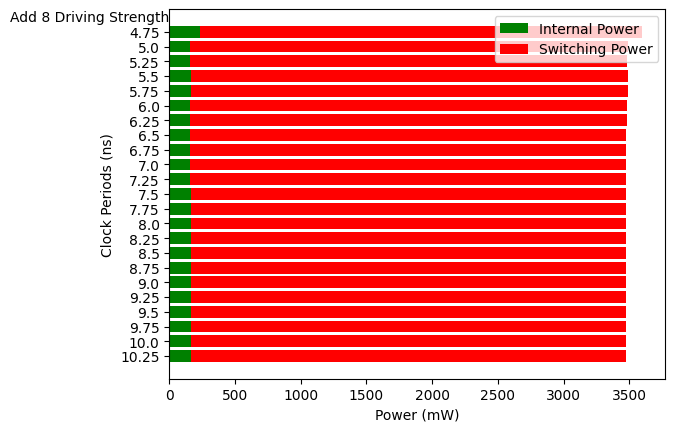

In [53]:
def get_test_name(tb_name):
    args = tb_name.replace('-', ' ').replace('ns', '').split()
    return args[5]

tests_sorted = [t for _,t in [(tests_dict[t]['total_power'],t) for t in tests_dict if 'total_power' in tests_dict[t]]]
power_sorted = [tests_dict[t]['total_power'] for t in tests_sorted]
switching = [tests_dict[t]['switching_power'] for t in tests_sorted]
internal = [tests_dict[t]['internal_power'] for t in tests_sorted]
area = [tests_dict[t]['area'] for t in tests_sorted]
names = list(map(get_test_name,tests_sorted))

fig, ax = plt.subplots()

y_pos = np.arange(len(names))

# ax.barh(y_pos, power_sorted, align='center')
ax.barh(y_pos, internal, align='center', color='g', label='Internal Power')
ax.barh(y_pos, switching, left=internal, align='center', color='r', label='Switching Power')
ax.set_yticks(y_pos, labels=names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Power (mW)')
ax.set_ylabel('Clock Periods (ns)')
plt.legend()
tb_name = 'Add 8 Driving Strength'
plt.text(-0.1,-1,tb_name,horizontalalignment='right',verticalalignment='center')
# plt.show()

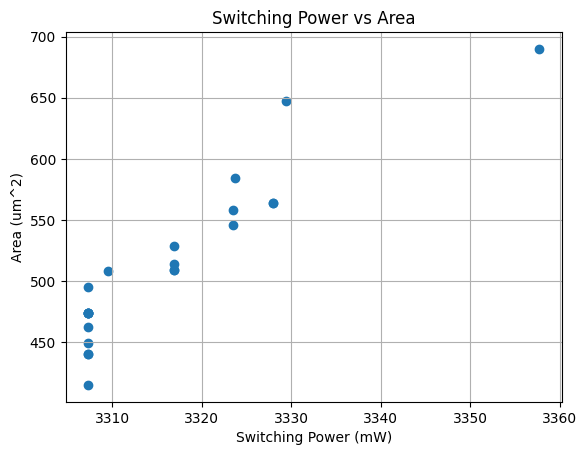

In [54]:
fig, ax = plt.subplots()
ax.scatter(switching, area)

ax.set(xlabel='Switching Power (mW)', ylabel='Area (um^2)',
       title='Switching Power vs Area')
ax.grid()

plt.show()

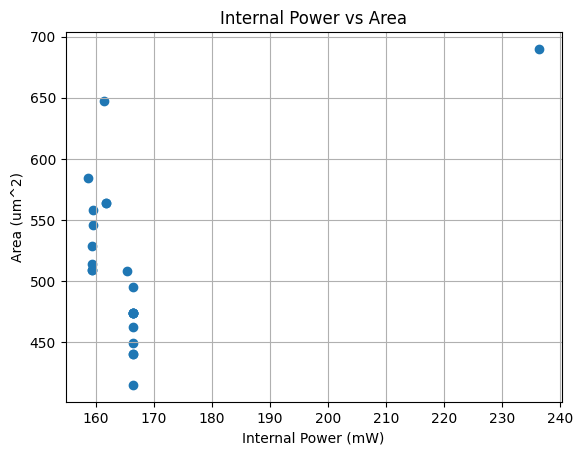

In [55]:
fig, ax = plt.subplots()
ax.scatter(internal, area)

ax.set(xlabel='Internal Power (mW)', ylabel='Area (um^2)',
       title='Internal Power vs Area')
ax.grid()

plt.show()